In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

### Generate synthetic travel-time measurements

In [72]:
np.random.seed(11)
vp = 6.0
vs = vp/1.73
num_event = 30
xmax = 100
station_loc = np.random.uniform(low=0, high=xmax, size=(5,2))
event_loc = np.random.uniform(low=0, high=xmax, size=(num_event,2))
event_t0 = np.random.uniform(low=0, high=xmax/vp, size=(num_event,1))

In [73]:
dist = np.linalg.norm(station_loc[np.newaxis,:,:] - event_loc[:,np.newaxis,:], axis=-1)
tp = dist / vp + event_t0
tp += np.random.rand(1, len(station_loc)) * 10
ts = dist / vs + event_t0
ts += np.random.rand(1, len(station_loc)) * 10

Visualize travel-time of the first event

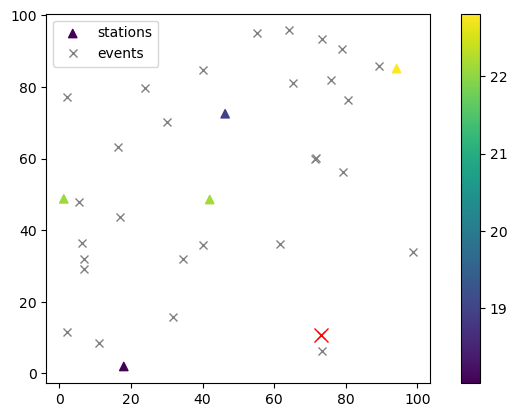

In [74]:
plt.figure()
idx_event = 0
plt.scatter(station_loc[:,0], station_loc[:,1], c=tp[idx_event,:], marker="^", label="stations")
plt.plot(event_loc[:,0], event_loc[:,1], 'x', color='gray', label="events")
plt.plot(event_loc[idx_event,0], event_loc[idx_event,1], 'rx', markersize=10)
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.legend()
plt.colorbar()
plt.axis("scaled")
plt.show()

### Build forward model for calculating travel-times

In [75]:
class TravelTime(nn.Module):
    def __init__(self, num_event=1, use_dd=False, dd_weight=10.0, dd_fast=True):
        super().__init__()
        self.num_event = num_event
        self.event_loc = nn.Parameter(torch.zeros(size=(num_event,2), dtype=torch.float64))
        self.event_t0 = nn.Parameter(torch.zeros(size=(num_event,1), dtype=torch.float64))
        self.use_dd = use_dd
        self.dd_weight = dd_weight
        self.dd_fast = dd_fast

    def calc_time(self, station_loc, velocity=torch.tensor([6.0]), batch_idx=None):

        if batch_idx is None:
          dist  = torch.linalg.norm(station_loc.unsqueeze(0) - self.event_loc.unsqueeze(1), axis=-1)
          tt = dist / velocity.unsqueeze(1).unsqueeze(1) + self.event_t0

        else:
          dist  = torch.linalg.norm(station_loc.unsqueeze(0) - self.event_loc[batch_idx].unsqueeze(1), axis=-1)
          tt = dist / velocity.unsqueeze(1).unsqueeze(1) + self.event_t0[batch_idx]

        return tt

    def forward(self, data, station_loc, velocity=torch.tensor([6.0]), batch_idx=None, mask=None):

        tt = self.calc_time(station_loc, velocity=velocity, batch_idx = batch_idx)
        dt = tt - data
        
        # if mask is None:
        #     # loss = torch.nn.functional.huber_loss(tt, data)
        #     # loss = torch.nn.functional.smooth_l1_loss(tt, data)
        #     # loss = torch.nn.functional.l1_loss(tt, data)
        #     loss = torch.nn.functional.mse_loss(tt, data)
        # else:
        #     loss = torch.nn.functional.huber_loss(tt, data, reduction='none')
        #     loss = (loss * mask.float()).sum() / mask.sum()

        loss = torch.mean(torch.abs(dt))
        if self.use_dd:
            if self.dd_fast:
                loss_dd = torch.mean(torch.abs(dt.unsqueeze(1) - dt.unsqueeze(2)))
                loss += self.dd_weight * loss_dd
            else:
                num = 0
                loss_dd = 0
                for i in range(dt.shape[1]):
                    for j in range(i+1, dt.shape[1]):
                        loss_dd += torch.mean(torch.abs(dt[:, i, :] - dt[:, j, :]))
                        num += 1
                loss += loss_dd / num

        return {"loss": loss}

In [76]:
data = torch.tensor(np.stack([tp, ts]))
station_loc = torch.from_numpy(station_loc)

### Locating earthquakes using absolute travel times

In [88]:
num_event = 1
num_event = len(event_loc)
travel_time = TravelTime(num_event, use_dd=False)
travel_time(data[:, 0:num_event, :], station_loc)
velocity=torch.tensor([vp, vs])

optimizer = optim.LBFGS(params=travel_time.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    output = travel_time(data[:, 0:num_event, :], station_loc, velocity=velocity)
    loss = output["loss"]
    loss.backward(retain_graph=True)
    return loss

optimizer.step(closure)
    
output = travel_time(data[:, 0:num_event, :], station_loc, velocity=velocity)
loss = output["loss"]
print(f"loss = {loss:.3f}")

loss = 1.384


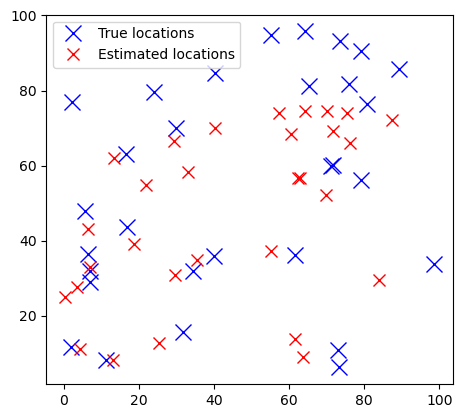

In [90]:
plt.figure()
# plt.scatter(station_loc[:,0], station_loc[:,1], c=tp[idx_event,:])
plt.plot(event_loc[:num_event,0], event_loc[:num_event,1], 'x', markersize=12, color='blue', label="True locations")
plt.plot(travel_time.event_loc.detach().numpy()[:num_event,0], travel_time.event_loc.detach().numpy()[:num_event,1], 'x', markersize=8, color='red', label="Estimated locations")
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.axis("scaled")
plt.legend()
plt.show()

### Locating earthquakes using both absolute travel-times and relative travel-time differences

In [92]:
travel_time = TravelTime(num_event, use_dd=True)
optimizer = optim.LBFGS(params=travel_time.parameters(), max_iter=1000, line_search_fn="strong_wolfe")
optimizer.step(closure)

output = travel_time(data[:, 0:num_event, :], station_loc, velocity=velocity)
loss = output["loss"]
print(f"loss = {loss:.3f}")

loss = 1.656


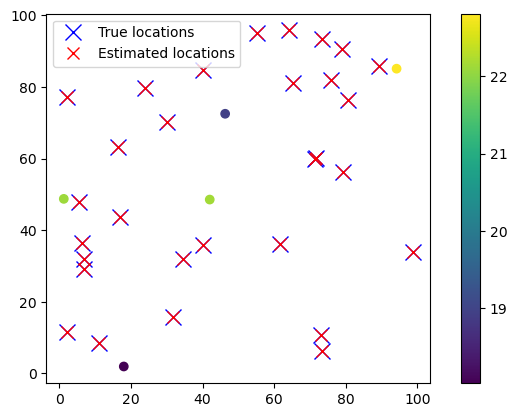

In [93]:
plt.figure()
plt.scatter(station_loc[:,0], station_loc[:,1], c=tp[idx_event,:])
plt.plot(event_loc[:num_event,0], event_loc[:num_event,1], 'x', markersize=12, color='blue', label="True locations")
plt.plot(travel_time.event_loc.detach().numpy()[:num_event,0], travel_time.event_loc.detach().numpy()[:num_event,1], 'x', markersize=8, color='red', label="Estimated locations")
plt.xlim([0, xmax])
plt.ylim([0, xmax])
plt.colorbar()
plt.axis("scaled")
plt.legend()
plt.show()